## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\cerbe\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

## 比較val_loss 和 val_acc為設置下的差異

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

earlystop_acc = EarlyStopping(monitor="val_acc", 
                          patience=5, 
                          verbose=1
                          )

earlystop_loss = EarlyStopping(monitor="val_loss", 
                          patience=5, 
                          verbose=1
                          )
EARLYSTOP = [earlystop_acc, earlystop_loss]

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
i=0
for stopper in EARLYSTOP:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[stopper]
             )
    
    if i == 0:
        stopper_name = 'val_acc'
    else:
        stopper_name = 'val_loss'
    
    # Collect results
    name_tag = 'stopper = %s'%str(stopper_name)
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    results[name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    i+=1





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
______

50000/50000 [==============================] - 2s 41us/step - loss: 2.1798 - acc: 0.2820 - val_loss: 2.0909 - val_acc: 0.3319
Epoch 2/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.7379 - acc: 0.3950 - val_loss: 1.7847 - val_acc: 0.3882
Epoch 3/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.6118 - acc: 0.4371 - val_loss: 1.6768 - val_acc: 0.4130
Epoch 4/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.5391 - acc: 0.4625 - val_loss: 1.6333 - val_acc: 0.4258
Epoch 5/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.4860 - acc: 0.4825 - val_loss: 1.5831 - val_acc: 0.4425
Epoch 6/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.4422 - acc: 0.4965 - val_loss: 1.5638 - val_acc: 0.4493
Epoch 7/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.4021 - acc: 0.5136 - val_loss: 1.5506 - val_acc: 0.4571
Epoch 8/50
50000/50000 [============================

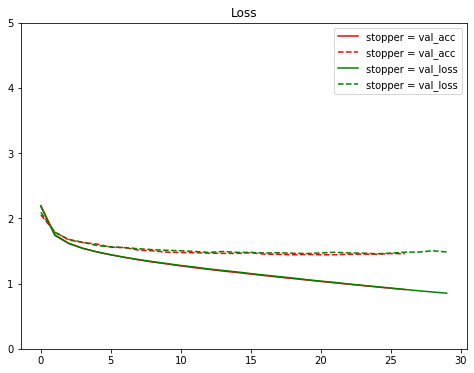

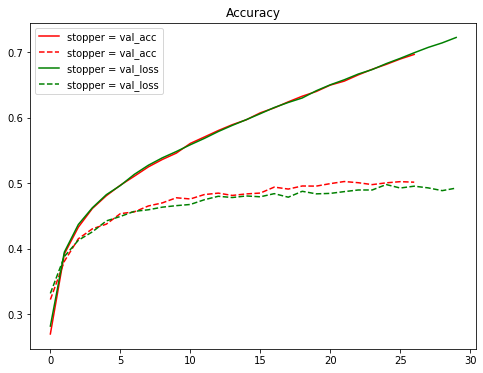

In [8]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

採用val_acc的話有提前結束的現象

## 調整 earlystop 的等待次數至 10, 25 並比較結果

In [9]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

earlystop_10 = EarlyStopping(monitor="val_loss", 
                          patience=10, 
                          verbose=1
                          )

earlystop_25 = EarlyStopping(monitor="val_loss", 
                          patience=25, 
                          verbose=1
                          )
EARLYSTOP = [earlystop_10, earlystop_25]

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
i=0
for stopper in EARLYSTOP:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[stopper]
             )
    
    if i == 0:
        stopper_name = 'stop at 10'
    else:
        stopper_name = 'stop at 25'
    
    # Collect results
    name_tag = 'stopper = %s'%str(stopper_name)
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    results[name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    i+=1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 2s 31us/step - loss: 1.3712 - acc: 0.5233 - val_loss: 1.5229 - val_acc: 0.4649
Epoch 9/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.3387 - acc: 0.5347 - val_loss: 1.5137 - val_acc: 0.4702
Epoch 10/50
50000/50000 [==============================] - 2s 32us/step - loss: 1.3076 - acc: 0.5475 - val_loss: 1.4961 - val_acc: 0.4822
Epoch 11/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.2783 - acc: 0.5575 - val_loss: 1.4877 - val_acc: 0.4807
Epoch 12/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.2525 - acc: 0.5660 - val_loss: 1.4901 - val_acc: 0.4816
Epoch 13/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.2273 - acc: 0.5767 - val_loss: 1.4766 - val_acc: 0.4825
Epoch 14/50
50000/50000 [==============================] - 2s 31us/step - loss: 1.2018 - acc: 0.5870 - val_loss: 1.4669 - val_acc: 0.4838
Epoch 15/50
50000/50000 [======================

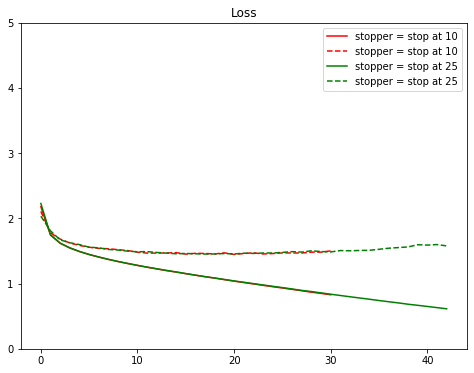

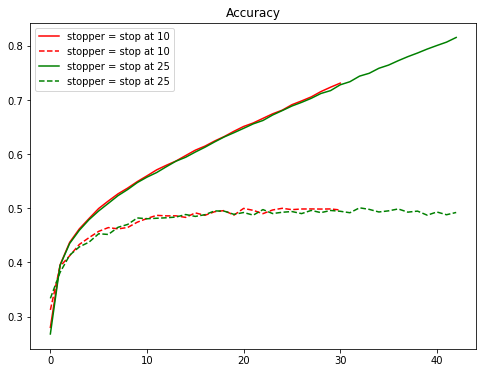

In [10]:
"""Code Here
將結果繪出
"""
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()